<a href="https://colab.research.google.com/github/beelittlehoney/CCADMACL_PROJECT_COM222/blob/main/cooking_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Pre-Processing

## Import Necessary Libraries

In [2]:
!pip install kagglehub
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

## Step 1: Load and Inspect the Data

In [3]:
file_path = "India_Condom_Market_Dataset.csv"

data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  'ankushpanday1/condom-market-size-in-india',
  file_path
)

data.head()

<ipython-input-3-ad052cacbe09>:3: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  data = kagglehub.load_dataset(


,Year,Market Size (USD Million),CAGR (%),Material Type,Product Type,Distribution Channel,Event Name,Event Date,Company Involved,Event Details,Region,Market Penetration,Growth Rate (%),Brand Name,Market Share (%),Revenue Contribution (%),Innovation Index,Regulatory Impact,Awareness Campaign Impact
0,2027,1119.93,10.20,Non-latex,Male Condoms,Drug Stores,Product Launch,2027-06-20,Sirona Hygiene Private Limited,Launched new product,West India,Medium,12.27,Durex,31.01,6.66,6.28,High,1.23
1,2024,1479.27,12.52,Latex,Male Condoms,Drug Stores,Campaign,2020-03-14,Godrej Consumer Products Limited,Acquired smaller brand,West India,Low,12.89,Playboy,35.78,14.97,2.70,Low,6.43
2,2023,894.44,9.31,Latex,Male Condoms,Drug Stores,Product Launch,2027-03-23,TTK,Ran awareness campaign,North India,Medium,10.55,Skore,29.22,4.99,5.66,Medium,3.64
3,2030,1181.72,12.77,Non-latex,Male Condoms,Mass Merchandisers,Product Launch,2028-07-01,Godrej Consumer Products Limited,Ran awareness campaign,West India,Low,9.68,Durex,28.97,2.86,4.38,Low,95.27
4,2023,1636.19,10.45,Non-latex,Female Condoms,Mass Merchandisers,Campaign,2030-04-11,HLL Lifecare Limited,Acquired smaller brand,South India,Medium,10.24,Skore,24.33,3.92,6.11,High,12.13


## Step 2: Handle Date-Related Columns

In [4]:
data['Event Date'] = pd.to_datetime(data['Event Date'], errors='coerce')
data['Year'] = data['Event Date'].dt.year  # Extract year for time series analysis
data.drop('Event Date', axis=1, inplace=True)

## Step 3: Clean and Transform Features

In [5]:
data.rename(columns={'CAGR (%)': 'CAGR(%)'}, inplace=True)
mapping = {'Low': 1, 'Medium': 2, 'High': 3}  # More robust handling of missing mappings

for col in ['Market Penetration', 'Growth Rate (%)', 'Innovation Index', 'Regulatory Impact', 'Awareness Campaign Impact']:
  data[col] = data[col].map(mapping)

## Step 4: Identify and Remove Columns with >90% Missing Values

In [6]:
missing_threshold = 0.9  # Threshold for missing data
initial_cols = data.columns #Save initial columns
missing_counts = data.isnull().sum() / len(data)
cols_to_drop = missing_counts[missing_counts > missing_threshold].index

print(f"Dropping columns with >{missing_threshold*100}% missing values: {list(cols_to_drop)}")
data.drop(cols_to_drop, axis=1, inplace=True)
final_cols = data.columns

Dropping columns with >90.0% missing values: ['Growth Rate (%)', 'Innovation Index', 'Awareness Campaign Impact']


## Step 5: Impute Numerical Features

In [7]:
numerical_features = data.select_dtypes(include=np.number).columns.tolist()
categorical_features = data.select_dtypes(exclude=np.number).columns.tolist()

print(f"Numerical Features:", numerical_features)
print(f"Categorical Features:", categorical_features)

# Remove any dropped column from the list of numerical features
numerical_features = [col for col in numerical_features if col in final_cols]

# Imputation using SimpleImputer
imputer = SimpleImputer(strategy='mean')
data[numerical_features] = imputer.fit_transform(data[numerical_features])

Numerical Features: ['Year', 'Market Size (USD Million)', 'CAGR(%)', 'Market Penetration', 'Market Share (%)', 'Revenue Contribution (%)', 'Regulatory Impact']
Categorical Features: ['Material Type', 'Product Type', 'Distribution Channel', 'Event Name', 'Company Involved', 'Event Details', 'Region', 'Brand Name']


## Step 6: Feature Engineering

1. Price Tier (Combine Market Size and Market Penetration)
* Assumptions: Higher market size and lower penetration could indicate higher prices.
* This is a rough proxy; actual price data would be better.



In [8]:
data['Price Tier'] = data['Market Size (USD Million)'] / data['Market Penetration']

#Normalize it to be between 1 and 3 for each year
data['Price Tier'] = data.groupby('Year')['Price Tier'].transform(lambda x: pd.qcut(x, q=3, labels=[1, 2, 3]))
data['Price Tier'] = data['Price Tier'].astype(int) # convert to int after assigning labels

print(data['Price Tier'])

0        1
1        3
2        1
3        3
4        2
        ..
49995    1
49996    3
49997    2
49998    3
49999    2
Name: Price Tier, Length: 50000, dtype: int64


2. Market Efficiency (Revenue Contribution / Market Share)
* A higher ratio suggests that the brand is efficiently converting market share into revenue.

In [9]:
data['Market Efficiency'] = data['Revenue Contribution (%)'] / data['Market Share (%)']

print(data['Market Efficiency'])

0        0.214769
1        0.418390
2        0.170773
3        0.098723
4        0.161118
           ...   
49995    0.471689
49996    0.083692
49997    0.201557
49998    0.278263
49999    0.134723
Name: Market Efficiency, Length: 50000, dtype: float64


3. Regulatory Compliance Risk (Combine Regulatory Impact and Market Share)
* High regulatory impact coupled with high market share may suggest higher compliance risk.

In [10]:
data['Regulatory Compliance Risk'] = data['Regulatory Impact'] * data['Market Share (%)']

print(data['Regulatory Compliance Risk'])

0         93.03
1         35.78
2         58.44
3         28.97
4         72.99
          ...  
49995     40.62
49996    118.65
49997     23.12
49998    113.31
49999     12.47
Name: Regulatory Compliance Risk, Length: 50000, dtype: float64


4. Interaction features between categorical variables
* Combining Region with Distribution Channel.

In [11]:
data['Region_Distribution'] = data['Region'] + '_' + data['Distribution Channel']

# Combining Material Type with Product Type
data['Material_Product'] = data['Material Type'] + '_' + data['Product Type']

In [12]:
print(data['Region_Distribution'])

0                West India_Drug Stores
1                West India_Drug Stores
2               North India_Drug Stores
3         West India_Mass Merchandisers
4        South India_Mass Merchandisers
                      ...              
49995     East India_Mass Merchandisers
49996            South India_E-Commerce
49997            South India_E-Commerce
49998           North India_Drug Stores
49999    North India_Mass Merchandisers
Name: Region_Distribution, Length: 50000, dtype: object


In [13]:
print(data['Material_Product'])

0          Non-latex_Male Condoms
1              Latex_Male Condoms
2              Latex_Male Condoms
3          Non-latex_Male Condoms
4        Non-latex_Female Condoms
                   ...           
49995    Non-latex_Female Condoms
49996    Non-latex_Female Condoms
49997        Latex_Female Condoms
49998        Latex_Female Condoms
49999        Latex_Female Condoms
Name: Material_Product, Length: 50000, dtype: object


## Step 7: Define Features and Create Subset

In [14]:
# Update numerical and categorical feature lists
numerical_features = ['Market Size (USD Million)', 'CAGR(%)', 'Market Penetration', 'Regulatory Impact', 'Market Share (%)', 'Revenue Contribution (%)', 'Year', 'Price Tier', 'Market Efficiency', 'Regulatory Compliance Risk']
categorical_features = ['Material Type', 'Product Type', 'Distribution Channel', 'Region', 'Region_Distribution', 'Material_Product']

all_features = numerical_features + categorical_features
print(f"All Features:", all_features)

All Features: ['Market Size (USD Million)', 'CAGR(%)', 'Market Penetration', 'Regulatory Impact', 'Market Share (%)', 'Revenue Contribution (%)', 'Year', 'Price Tier', 'Market Efficiency', 'Regulatory Compliance Risk', 'Material Type', 'Product Type', 'Distribution Channel', 'Region', 'Region_Distribution', 'Material_Product']


## Step 8: Create ColumnTransformer

In [15]:
preprocessor = ColumnTransformer(
  transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
  ]
)

## Step 9: Fit and Transform Data

In [16]:
processed_data = preprocessor.fit_transform(data)

## Step 10: Create Processed DataFrame

In [17]:
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
processed_df = pd.DataFrame(processed_data,
                            columns=numerical_features + list(ohe_feature_names))

## Step 11: Check for NaN values in processed_df

In [18]:
print("NaN values in processed_df after one-hot encoding:")

nan_counts = processed_df.isnull().sum()
nan_counts = nan_counts[nan_counts > 0]  # Filter only columns with NaN values

for i, (col, count) in enumerate(nan_counts.items(), 1):
  print(f"{i}. {col}: {count} NaN values")

NaN values in processed_df after one-hot encoding:


## Step 12: Drop the all-NaN columns from processed_df

In [19]:
dropped_columns = [col for col in initial_cols if col not in final_cols]

print("Dropped Columns from processed_df:")
for i, col in enumerate(dropped_columns, 1):
  print(f"{i}. {col}")

processed_df.drop(columns=dropped_columns, errors='ignore', inplace=True)

Dropped Columns from processed_df:
1. Growth Rate (%)
2. Innovation Index
3. Awareness Campaign Impact


## Step 13: Check if there are any remaining NaN values

In [20]:
print("Remaining NaN values in processed_df after dropping all-NaN columns:")

nan_counts = processed_df.isnull().sum()
nan_counts = nan_counts[nan_counts > 0]  # Filter only columns with NaN values

for i, (col, count) in enumerate(nan_counts.items(), 1):
  print(f"{i}. {col}: {count} NaN values")

Remaining NaN values in processed_df after dropping all-NaN columns:


# Model Building

## Step 14: K-Means Clustering

1. Elbow Method

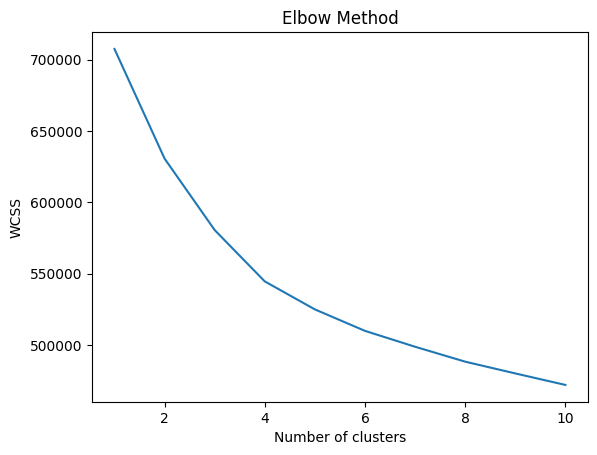

In [22]:
wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(processed_df)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

2. Silhouette Score Method

For n_clusters = 2 The average silhouette_score is : 0.09946183350859016
For n_clusters = 3 The average silhouette_score is : 0.09645894950526937
For n_clusters = 4 The average silhouette_score is : 0.09270663702330403
For n_clusters = 5 The average silhouette_score is : 0.08166359913765417
For n_clusters = 6 The average silhouette_score is : 0.0784690486319192
For n_clusters = 7 The average silhouette_score is : 0.07433513478204366
For n_clusters = 8 The average silhouette_score is : 0.07226877035229268
For n_clusters = 9 The average silhouette_score is : 0.06743584636309606
For n_clusters = 10 The average silhouette_score is : 0.06689844575544424


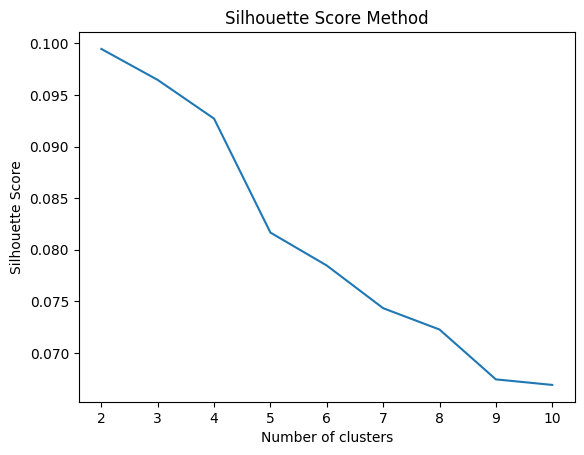

In [23]:
silhouette_scores = []
for n_cluster in range(2, 11):
  kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=300, n_init=10, random_state=0)
  cluster_labels = kmeans.fit_predict(processed_df)
  silhouette_avg = silhouette_score(processed_df, cluster_labels)
  silhouette_scores.append(silhouette_avg)
  print("For n_clusters =", n_cluster,
        "The average silhouette_score is :", silhouette_avg)

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

3. Apply K-Means clustering

In [24]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(processed_df)

4. Create a mapping from original index to cluster label

In [25]:
cluster_mapping = dict(zip(processed_df.index, cluster_labels))

5. Map the cluster labels back to the original dataframe, preserving the index

In [26]:
data['Cluster'] = data.index.map(cluster_mapping)

6. Display cluster assignments

In [27]:
print(data[['Brand Name', 'Region', 'Cluster']].head())

  Brand Name       Region  Cluster
0      Durex   West India        0
1    Playboy   West India        3
2      Skore  North India        2
3      Durex   West India        3
4      Skore  South India        0


7. Apply PCA for Visualization

In [28]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(processed_df)

8. Create a PCA DataFrame

In [29]:
# Create a PCA DataFrame
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = data['Cluster']

9. Plot the Clusters using PCA

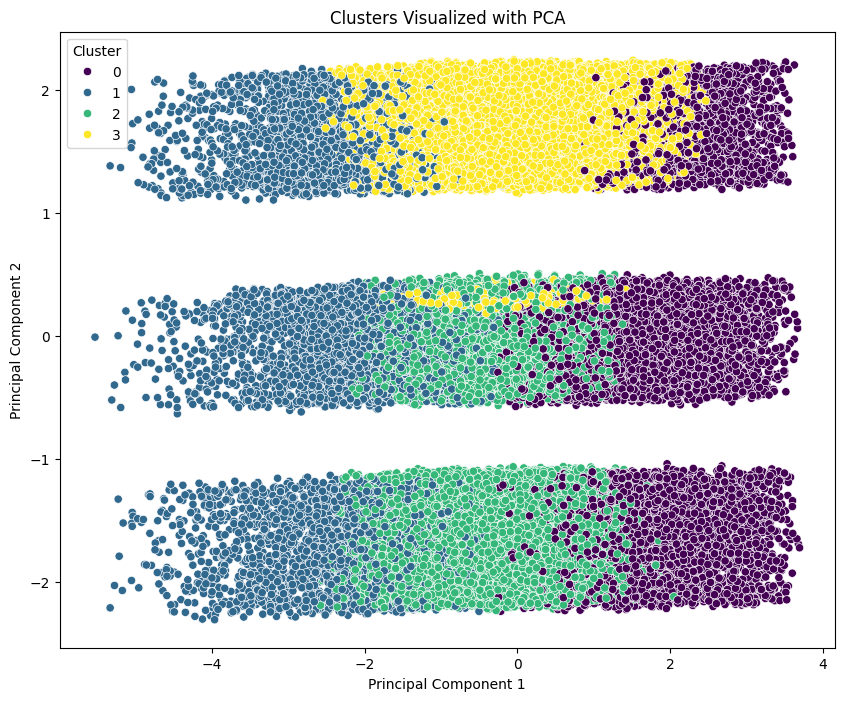

In [30]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Step 15: DBSCAN Clustering

1. Apply DBSCAN clustering

In [31]:
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
cluster_labels = dbscan.fit_predict(processed_df)

2. Create a mapping from original index to cluster label

In [32]:
cluster_mapping = dict(zip(processed_df.index, cluster_labels))

3. Map the cluster labels back to the original dataframe, preserving the index

In [33]:
data['DBSCAN_Cluster'] = data.index.map(cluster_mapping)

4. Display cluster assignments

In [34]:
print(data[['Brand Name', 'Region', 'DBSCAN_Cluster']].head())

  Brand Name       Region  DBSCAN_Cluster
0      Durex   West India              -1
1    Playboy   West India              -1
2      Skore  North India              -1
3      Durex   West India              -1
4      Skore  South India              -1


5. Apply PCA for Visualization

In [35]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(processed_df)

6. Create a PCA DataFrame

In [36]:
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['DBSCAN_Cluster'] = data['DBSCAN_Cluster']

7. Plot the Clusters using PCA

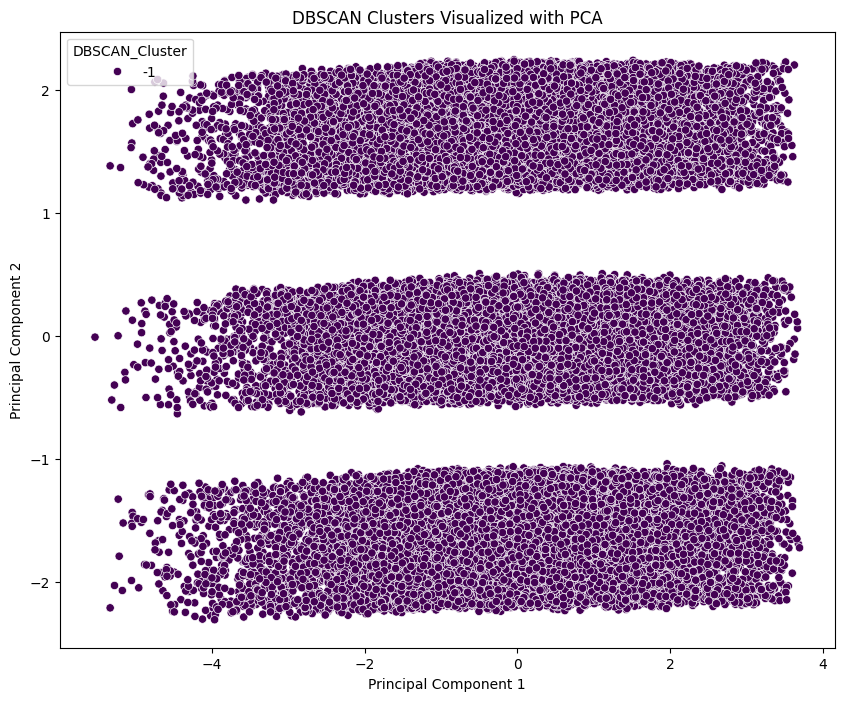

In [37]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=pca_df, palette='viridis')
plt.title('DBSCAN Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Results

## Step 16: Analyze Cluster Characteristics

In [41]:
cluster_summary = data.groupby('Cluster').agg({
  'Market Size (USD Million)': 'mean',
  'CAGR(%)': 'mean',
  'Market Penetration': 'mean',
  # 'Growth Rate (%)': 'mean', # Removed because some of these are not in the DataFrame.
  # 'Innovation Index': 'mean',
  # 'Awareness Campaign Impact': 'mean',
  'Regulatory Impact': 'mean',
  'Market Share (%)': 'mean',
  'Revenue Contribution (%)':'mean',
  'Material Type': lambda x: x.value_counts().index[0],
  'Product Type': lambda x: x.value_counts().index[0],
  'Distribution Channel': lambda x: x.value_counts().index[0],
  'Region': lambda x: x.value_counts().index[0],
  'Brand Name': lambda x: x.value_counts().index[0]
})

print(cluster_summary)

         Market Size (USD Million)    CAGR(%)  Market Penetration  \
Cluster                                                             
0                      1394.654508  10.524991            2.214952   
1                      1410.347530  10.515122            2.052742   
2                      1341.038870  10.501476            2.576943   
3                      1462.629016  10.491444            1.086428   

         Regulatory Impact  Market Share (%)  Revenue Contribution (%)  \
Cluster                                                                  
0                 2.720168         31.090555                  8.193670   
1                 2.056209         10.136983                 11.367281   
2                 1.539422         21.814665                  6.744947   
3                 1.811875         22.739775                  7.276523   

        Material Type    Product Type Distribution Channel         Region  \
Cluster                                                        

## Step 17: Visualize Results

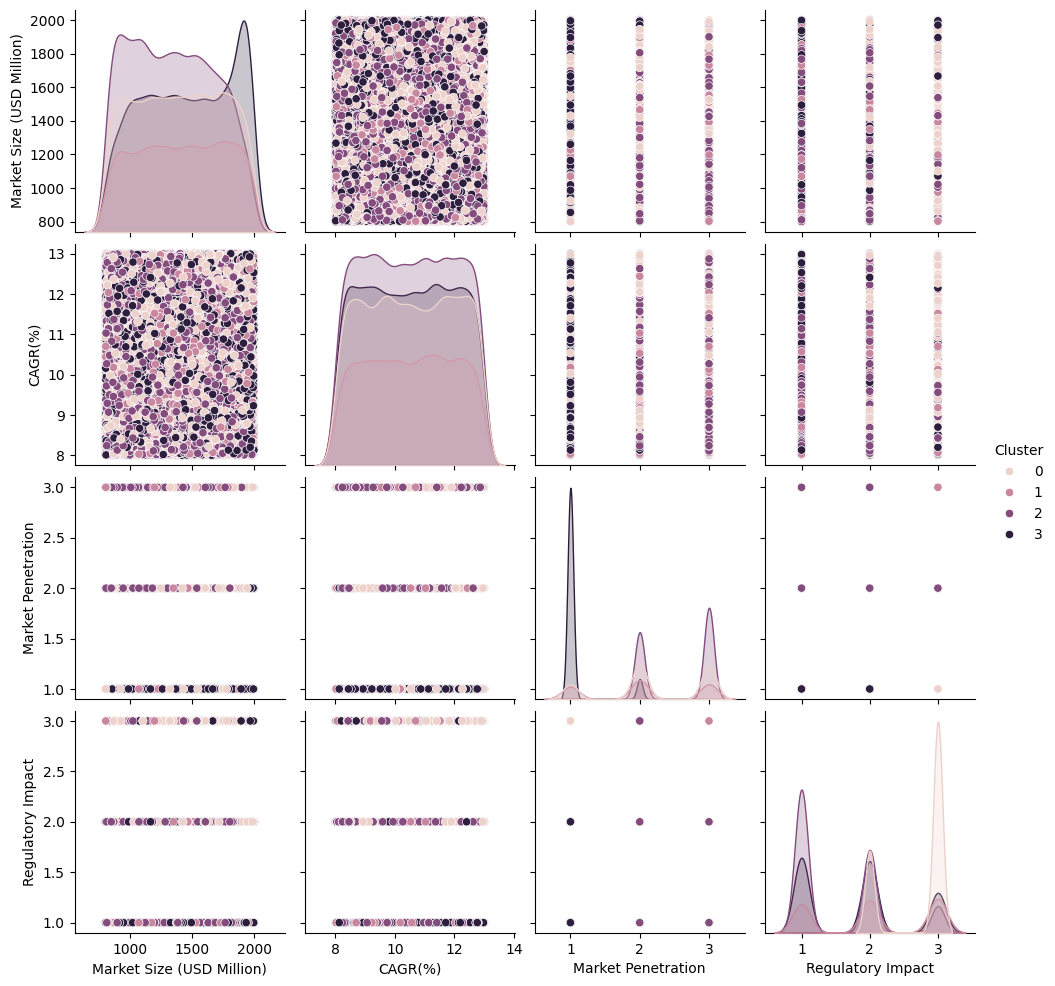

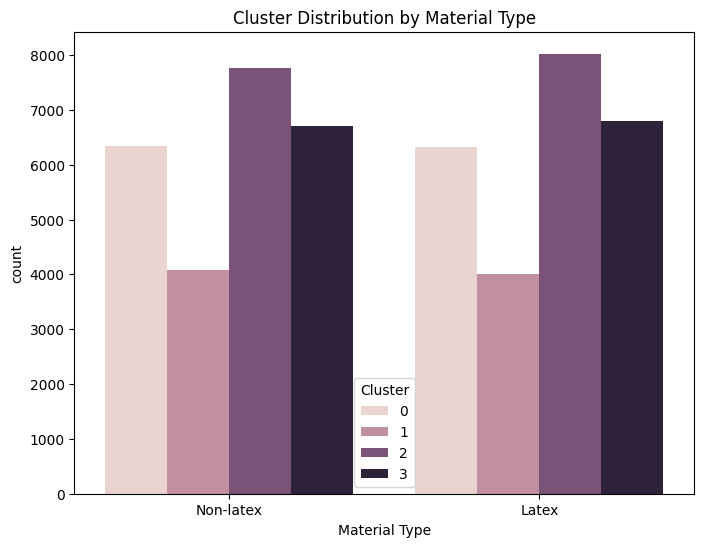

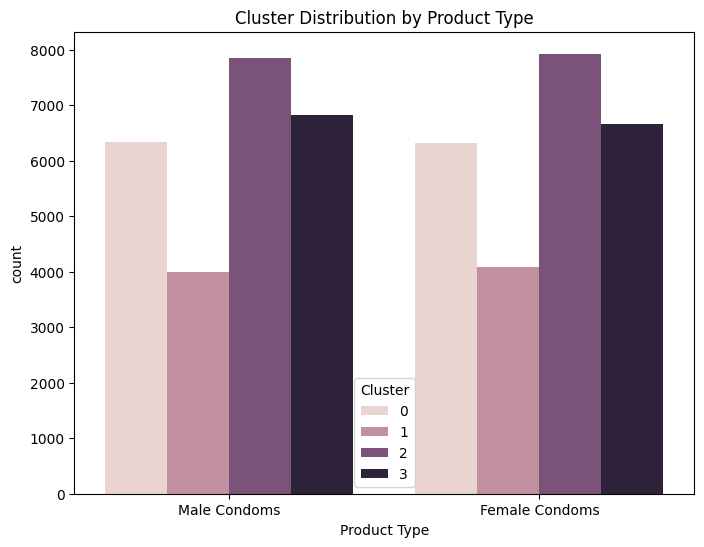

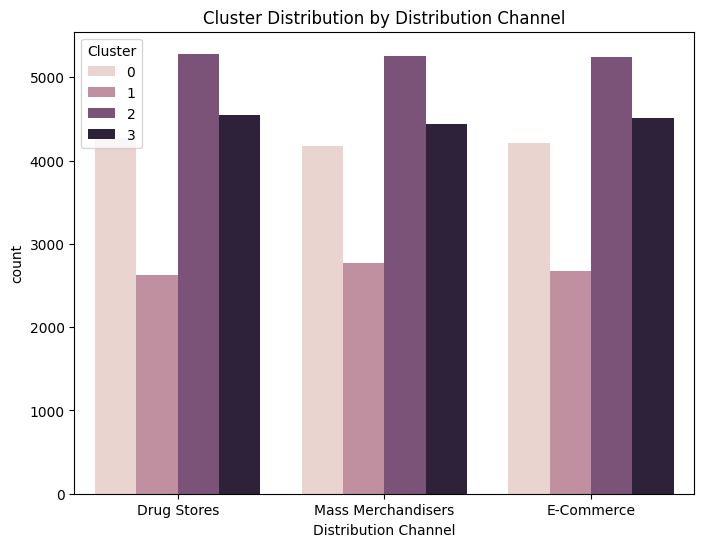

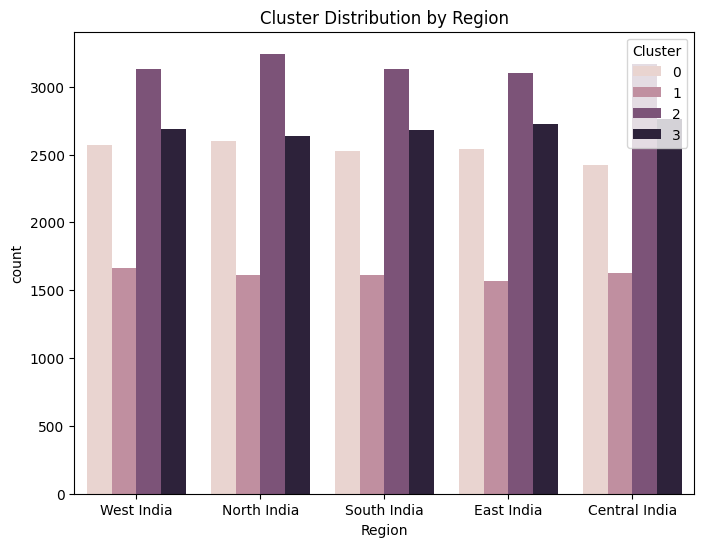

In [42]:
sns.pairplot(data, hue='Cluster', vars=['Market Size (USD Million)', 'CAGR(%)', 'Market Penetration', 'Regulatory Impact'])
plt.show()

for feature in ['Material Type', 'Product Type', 'Distribution Channel', 'Region']:
  plt.figure(figsize=(8, 6))
  sns.countplot(data=data, x=feature, hue='Cluster')
  plt.title(f'Cluster Distribution by {feature}')
  plt.show()

## Step 18: Time Series Analysis

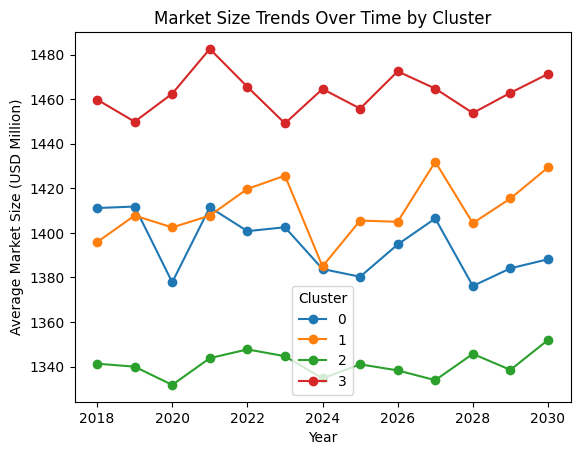

In [43]:
yearly_cluster_summary = data.groupby(['Year', 'Cluster'])['Market Size (USD Million)'].mean().unstack()
yearly_cluster_summary.plot(kind='line', marker='o')
plt.title('Market Size Trends Over Time by Cluster')
plt.xlabel('Year')
plt.ylabel('Average Market Size (USD Million)')
plt.legend(title='Cluster')
plt.show()

## Step 19: Show Heat Index Correlation

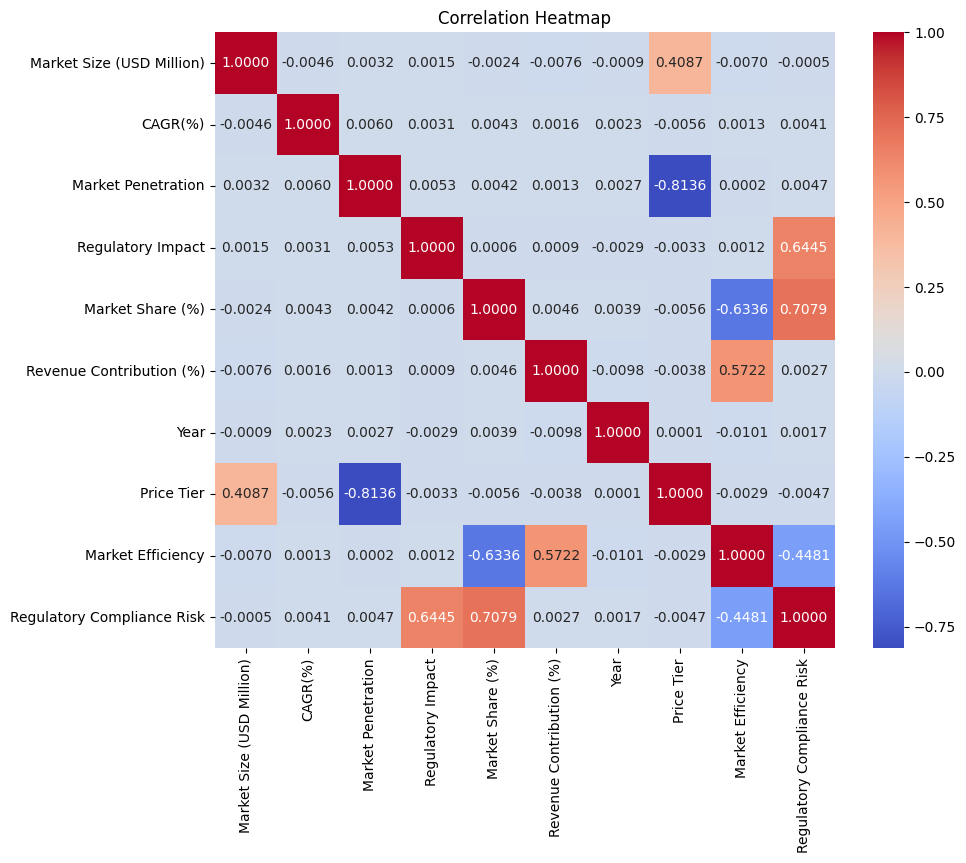

In [44]:
correlation_matrix = data[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Correlation Heatmap')
plt.show()